In [ ]:
!pip install langchain pypdf openai tiktoken

In [ ]:
!wget https://www.brandonsanderson.com/wp-content/uploads/2020/02/Warbreakerfull6.1.pdf

In [ ]:
import os
os.environ['OPENAI_API_KEY']='insert you api key here ...'

In [ ]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(temperature=0,model="gpt-3.5-turbo-0613")

In [ ]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("Warbreakerfull6.1.pdf")
pages = loader.load()
pages = pages[7:107]
# Combine the pages, and replace the tabs with spaces
text = ""
for page in pages:
    text += page.page_content

text = text.replace('\t', ' ')

In [ ]:
text

In [ ]:
num_tokens = llm.get_num_tokens(text)

print (f"This book has {num_tokens} tokens in it")

This book has 40099 tokens in it


CRESS Steps:

1. Load your book into a single text file
2. Split your text into large-ish chunks
3. Embed your chunks to get vectors
4. Cluster the vectors to see which are similar to each other and likely talk about the same parts of the book
5. Pick embeddings that represent the cluster the most (method: closest to each cluster centroid)
6. Summarize the documents that these embeddings represent


In [ ]:
from langchain.schema import Document

from langchain.text_splitter import TokenTextSplitter

from langchain.chat_models import ChatOpenAI

from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

from langchain.chains.summarize import load_summarize_chain

import numpy as np
from sklearn.cluster import KMeans

I'll use gpt 3.5 for the first set of summaries to reduce cost and then gpt4 for the final pass which should hopefully increase the quality.

In [ ]:
text_splitter = TokenTextSplitter(chunk_size=1000, chunk_overlap=500)

docs = text_splitter.create_documents([text])

In [ ]:
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 88 documents


In [ ]:
num_documents

88

In [ ]:
embeddings = OpenAIEmbeddings()

vectors = embeddings.embed_documents([x.page_content for x in docs])

In [ ]:
num_clusters = 11

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)
print(kmeans.labels_)

[ 3  3  3  3  3  3  3  3  3  1  4  4  4  4  4  5  5  5  5  5  5  1  1  1
  1  1  1  1  1  2  2  2  2  9  9  9  9  9  2  9  9  4  1  1  1  1  3  3
  8  8  8  8  8  9  2  9  9  6  6  6  6  6  6  0  0  6  6  3  6  6  6 10
 10  9  7  7  7  7  7  7  7  1 10 10  6  6  6  6]


In [ ]:
kmeans.labels_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  5,  5,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  0,  6,  6,  6,  2,  2,  2,  2,  9,
        9,  9,  9,  9,  2,  2,  2,  0,  0,  0,  0,  1,  1,  1,  8,  8,  8,
        8,  7,  2,  2,  2,  2,  7,  7,  7,  7,  7,  7,  7,  3,  3,  3,  1,
        7,  7,  7,  0,  7, 10,  4,  4,  4, 10, 10, 10, 10, 10,  7,  7,  7,
        7,  7,  7], dtype=int32)

In [ ]:
vectors=np.array(vectors)

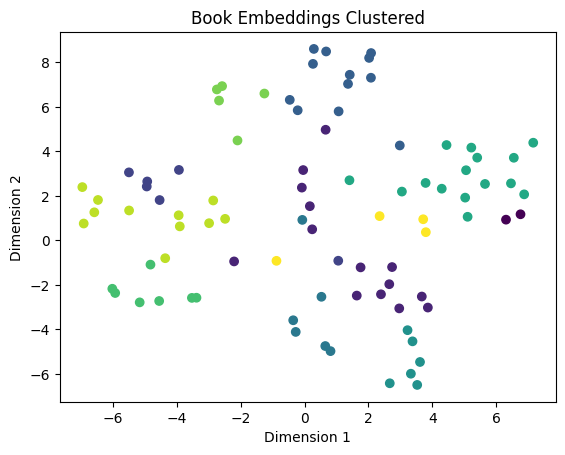

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(vectors)

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [ ]:
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [ ]:
#Now sort them (so the chunks are processed in order)
selected_indices = sorted(closest_indices)
selected_indices

[0, 13, 17, 24, 32, 35, 49, 63, 77, 83, 85]

In [ ]:
from langchain import PromptTemplate

In [ ]:
gpt35 = ChatOpenAI(temperature=0,model='gpt-3.5-turbo')
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])
map_chain = load_summarize_chain(llm=gpt35,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [ ]:
selected_docs = [docs[doc] for doc in selected_indices]
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):

    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])

    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n")

Summary #0 (chunk #0) - Preview: In this passage, Vasher is in a cell and is being ignored by a guard. The guard finds a sword in Vasher's bag and is surprised by its weight. When the guard undoes the clasp on the sword, the colors in the room deepen and grow stronger. Vasher warns  

Summary #1 (chunk #13) - Preview: In this passage, Siri and Mab are discussing the potential threat from the Hallandrens. Siri believes that the Hallandrens will leave them alone as long as they have a treaty and her father and sister, Vivenna, are in charge. However, Mab expresses c 

Summary #2 (chunk #17) - Preview: In this passage, Dedelin, the king of Idris, is discussing a difficult decision with his advisor, Yarda. They are considering sending Dedelin's daughter, Vivenna, to Hallandren, a rival kingdom, as part of a treaty agreement. Dedelin is hesitant to s 

Summary #3 (chunk #24) - Preview: In this passage, Vivenna, the older sister, is feeling resentful and betrayed by her father's decision to 

In [ ]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 3438 tokens


takes a while to run

In [ ]:
gpt4 = ChatOpenAI(temperature=0,model='gpt-4',request_timeout=120)
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])
reduce_chain = load_summarize_chain(llm=gpt4,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
                            )
output = reduce_chain.run([summaries])